In [29]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from PIL import Image
import PIL
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


In [30]:
classes = np.array(['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'])
l_num = {'0':0, '1':1, '2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9}


In [31]:
#The model class used for main experiment

class LeNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1)
        self.pool = nn.MaxPool2d(2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1)
        self.pool = nn.MaxPool2d(2, stride = 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
'''Model class used for experimenting with BatchNorm layer, here BatchNorm is used only after the first layer 
without Learnable parameters '''

class LeNetExp(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1)
        self.conv1_bn=nn.BatchNorm2d(6,affine=False)
        self.pool = nn.MaxPool2d(2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1)
        self.pool = nn.MaxPool2d(2, stride = 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.relu(self.conv1_bn(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [33]:
#Model class with BatchNorm layer after every ConvLayer and FCLayer

class LeNetBatch(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1)
        self.conv1_bn=nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1)
        self.conv2_bn=nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, stride = 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1_bn=nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn=nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.relu(self.conv1_bn(x)))
        x = self.conv2(x)
        x = self.pool(F.relu(self.conv2_bn(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = F.relu(self.fc1_bn(x))
        x = self.fc2(x)
        x = F.relu(self.fc2_bn(x))
        x = self.fc3(x)
        return x

In [34]:
def normalize(train_ds,test_ds,val_ds,test_loader,val_loader,train_loader):

    pixel_sum = torch.tensor([0.0, 0.0, 0.0])
    pixel_sum_sq = torch.tensor([0.0, 0.0, 0.0])

    for i, data in enumerate(train_loader, 0):

            inputs = data['image']
            pixel_sum += inputs.sum(axis = [0,2,3])
            pixel_sum_sq += (inputs ** 2).sum(axis = [0,2,3])

    count = len(train_ds) * 32 * 32

    total_mean = pixel_sum/count
    total_var = (pixel_sum_sq/count) - (total_mean ** 2)
    total_std = torch.sqrt(total_var)

    # print('mean:' + str(total_mean))
    # print('std:' + str(total_std))

In [35]:
#The Dataset class used to load the images into the dataset

class lenetdatatset(Dataset):

    def __init__ (self,filename):
        with open(filename) as f:
            self.lines = f.readlines()

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, index):
        im_lab = self.lines[index].split()
        img = Image.open('./'+ im_lab[0])
        transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(32), transforms.Normalize(mean = [0.4469, 0.4399, 0.4067], std = [0.2603, 0.2565, 0.2712])])
        img_tr = transform(img)
        label = l_num[im_lab[1]]
        #Each Dataset member is a dictionary with image,label pair
        sample = {'image': img_tr, 'label': label}
        return sample

In [36]:
#Plot confusion matrix as a heat map to analyze it better

def plot_cfm(labs,preds):

    cfmatrix = confusion_matrix(labs,preds)
    print('\nConfusion Matrix:\n',cfmatrix)

    df_cfm = pd.DataFrame(cfmatrix, index = classes, columns = classes)
    plt.figure(figsize = (20,14))
    cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='.3g')
    return cfm_plot
    

In [37]:
#Plot the training loss and Validation loss

def plot_loss(train_loss,val_loss):

    plt.plot(train_loss, 'g', label='Training loss')
    plt.plot(val_loss, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    return plt

In [38]:
#Function to train the model and check performance

def experiment(train_ds,test_ds,val_ds,test_loader,val_loader,net,optimizer,exp_name):

    train_loss = []
    val_loss = []

    #gamma indicates the decay of the learning rate after every 2 epoches
    scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    criterion = nn.CrossEntropyLoss()
    print('TRAINING')

    #training the model
    for epoch in range(40):

        running_loss = 0.0
        validation_loss = 0.0
        
        #Shuffles the train data after epoch
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)

        #Iterate over the batches and train the model
        for i, data in enumerate(train_loader, 0):

            inputs = data['image']
            labels = data['label']
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() #Keeping track of the training loss

        # checking validation loss for each epoch
        with torch.no_grad():

            for j, data in enumerate(val_loader, 0):

                inputs = data['image']
                labels = data['label']
                v_outputs = net(inputs)
                v_loss = criterion(v_outputs, labels)

                validation_loss += v_loss.item() #Keeping track of the validation loss

        #Keeping track of the avg loss of the current epoch over the different batches
        avg_train_loss = running_loss/len(train_loader) 
        avg_val_loss = validation_loss/len(val_loader)
        print('\nEPOCH: {}/40'.format(epoch))
        print('Train Loss: {:.4f}    Validation Loss: {:.4f}'.format(avg_train_loss,avg_val_loss))
        train_loss.append(avg_train_loss)
        val_loss.append(avg_val_loss)

    #plotting losses
    plot = plot_loss(train_loss,val_loss)
    plot.savefig(exp_name+'loss.png')

    #testing on test data
    correct = 0
    total = 0
    wcount = 0
    preds = []
    labs = []

    #class wise accuracy and confusion matrix for the whole classification
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    #Using test data to check the performance of the model
    with torch.no_grad():
        
        #Iterating over the batches
        for data in test_loader:
            count = 0
            inputs = data['image']
            labels = data['label']
            outputs = net(inputs)
            
            #Getting the max to assign the image to a class
            _, predictions = torch.max(outputs, 1) 

            preds.extend(predictions.numpy())
            labs.extend(labels.numpy())
            
            # collect the correct predictions for each class
            for idx, label, prediction in zip(range(labels.size(dim=0)),labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                    correct += 1
                else:
                    if count == 0 and wcount<5:
                        wimage = inputs[idx]
                        torchvision.utils.save_image(wimage, 'wrong'+str(wcount)+exp_name+'.png')
                        count += 1
                        wcount += 1
                total_pred[classes[label]] += 1
                total += 1

    print('\nAccuracy of the network on the test images: %d %%' % (100 * correct / total),'\n')
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    #confusion matrix
    cfm_plot = plot_cfm(labs,preds)
    cfm_plot.figure.savefig(exp_name+'cfm.png')




Main experiment

TRAINING

EPOCH: 0/40
Train Loss: 2.1412    Validation Loss: 2.0157

EPOCH: 1/40
Train Loss: 1.8842    Validation Loss: 1.8056

EPOCH: 2/40
Train Loss: 1.6988    Validation Loss: 1.7025

EPOCH: 3/40
Train Loss: 1.6443    Validation Loss: 1.6334

EPOCH: 4/40
Train Loss: 1.5726    Validation Loss: 1.6137

EPOCH: 5/40
Train Loss: 1.5328    Validation Loss: 1.6455

EPOCH: 6/40
Train Loss: 1.5226    Validation Loss: 1.5850

EPOCH: 7/40
Train Loss: 1.4563    Validation Loss: 1.5585

EPOCH: 8/40
Train Loss: 1.4175    Validation Loss: 1.5231

EPOCH: 9/40
Train Loss: 1.3856    Validation Loss: 1.5613

EPOCH: 10/40
Train Loss: 1.3675    Validation Loss: 1.4945

EPOCH: 11/40
Train Loss: 1.3069    Validation Loss: 1.5516

EPOCH: 12/40
Train Loss: 1.2808    Validation Loss: 1.4992

EPOCH: 13/40
Train Loss: 1.2546    Validation Loss: 1.5437

EPOCH: 14/40
Train Loss: 1.2143    Validation Loss: 1.5039

EPOCH: 15/40
Train Loss: 1.1864    Validation Loss: 1.4843

EPOCH: 16/40
Train Los

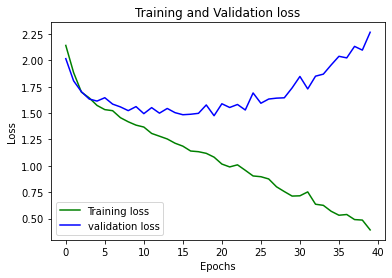

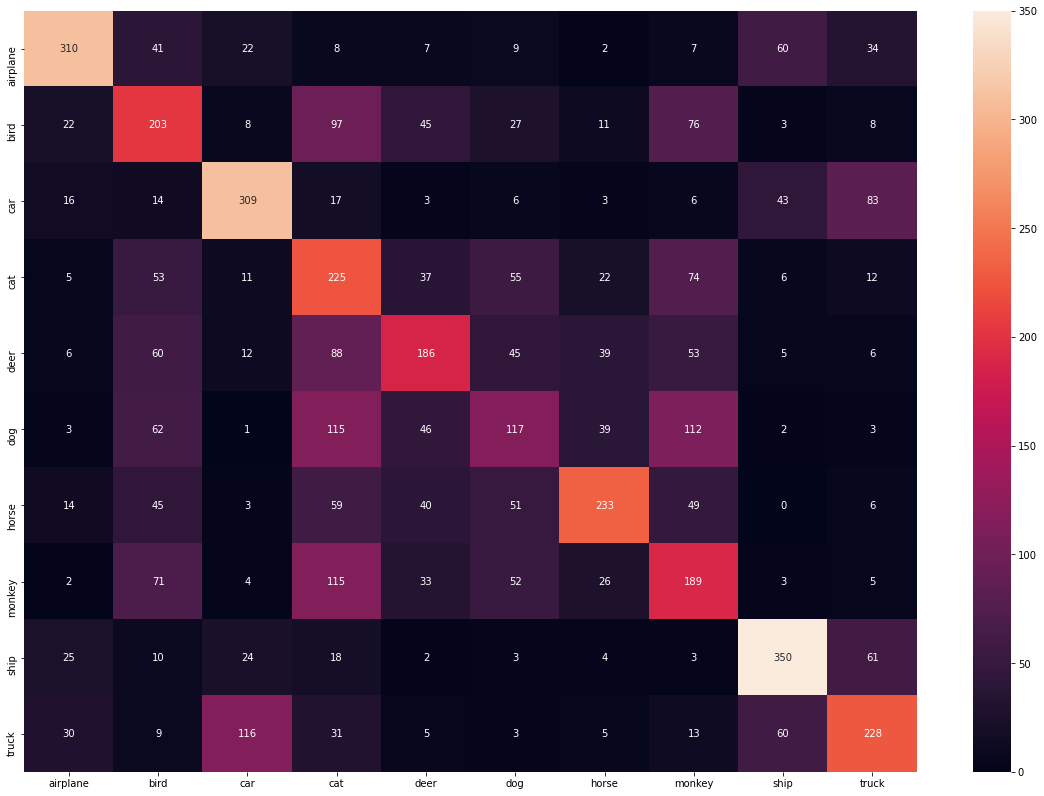

In [39]:
if __name__ == "__main__":

    #Loading the dataset
    train_ds = lenetdatatset(filename = 'splits/train.txt')
    test_ds = lenetdatatset(filename = 'splits/test.txt')
    val_ds = lenetdatatset(filename = 'splits/val.txt')
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=128, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=128, num_workers=0)
    
    #Main model
    print('\nMain experiment\n')
    exp_name = 'main'
    net = LeNet()
    optimizer  = optim.Adam(net.parameters(),lr=1e-3)
    experiment(train_ds,test_ds,val_ds,test_loader,val_loader,net,optimizer,exp_name)
    


L2 norm experiment

TRAINING

EPOCH: 0/40
Train Loss: 2.1184    Validation Loss: 1.9228

EPOCH: 1/40
Train Loss: 1.8608    Validation Loss: 1.7717

EPOCH: 2/40
Train Loss: 1.7053    Validation Loss: 1.6771

EPOCH: 3/40
Train Loss: 1.6243    Validation Loss: 1.5757

EPOCH: 4/40
Train Loss: 1.5400    Validation Loss: 1.6258

EPOCH: 5/40
Train Loss: 1.5120    Validation Loss: 1.5358

EPOCH: 6/40
Train Loss: 1.4710    Validation Loss: 1.4797

EPOCH: 7/40
Train Loss: 1.4422    Validation Loss: 1.5592

EPOCH: 8/40
Train Loss: 1.4331    Validation Loss: 1.5433

EPOCH: 9/40
Train Loss: 1.3986    Validation Loss: 1.4611

EPOCH: 10/40
Train Loss: 1.3456    Validation Loss: 1.4357

EPOCH: 11/40
Train Loss: 1.3409    Validation Loss: 1.4193

EPOCH: 12/40
Train Loss: 1.2891    Validation Loss: 1.4319

EPOCH: 13/40
Train Loss: 1.2596    Validation Loss: 1.4235

EPOCH: 14/40
Train Loss: 1.2337    Validation Loss: 1.3919

EPOCH: 15/40
Train Loss: 1.1999    Validation Loss: 1.3967

EPOCH: 16/40
Train 

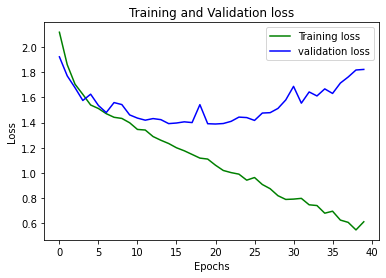

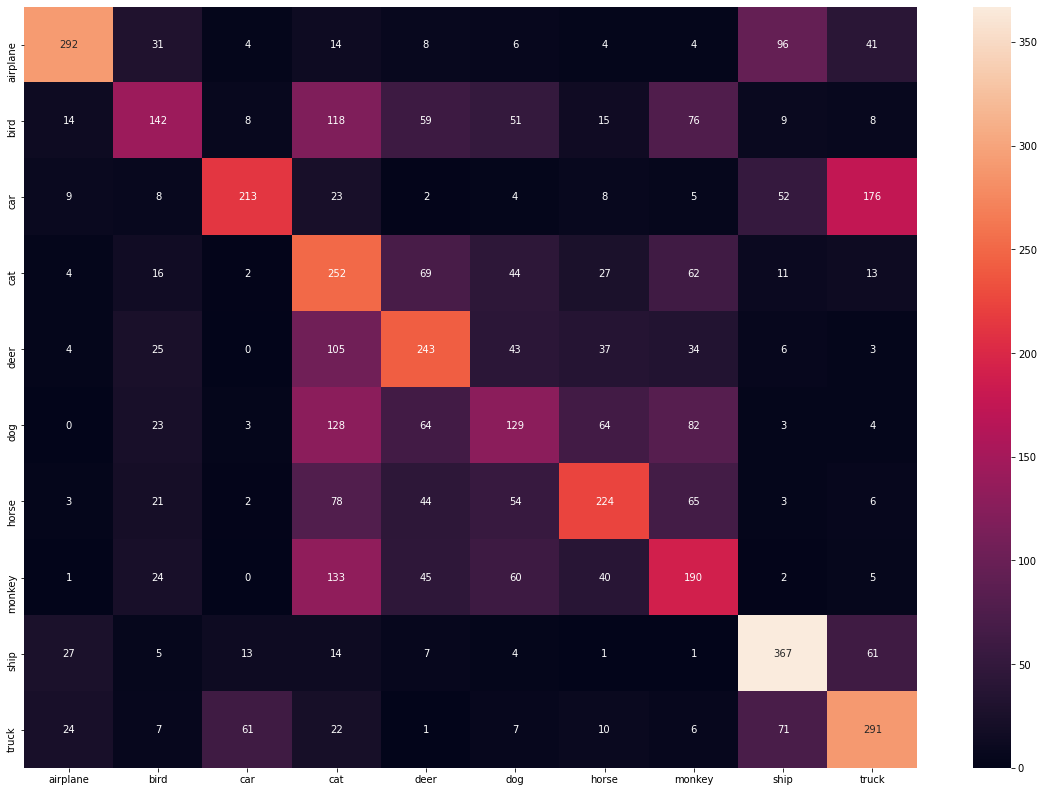

In [40]:
    
    #Experiment with L2 norm(decay = 1e-3)
    print('\nL2 norm experiment\n')
    exp_name = 'L2norm'
    netl2 = LeNet()
    optimizer = optim.Adam(netl2.parameters(),lr = 1e-3, weight_decay = 1e-3)
    experiment(train_ds,test_ds,val_ds,test_loader,val_loader,netl2,optimizer,exp_name)
    


Batch Normalization

TRAINING

EPOCH: 0/40
Train Loss: 1.8842    Validation Loss: 2.6266

EPOCH: 1/40
Train Loss: 1.5470    Validation Loss: 2.7739

EPOCH: 2/40
Train Loss: 1.3929    Validation Loss: 2.9125

EPOCH: 3/40
Train Loss: 1.2518    Validation Loss: 3.1038

EPOCH: 4/40
Train Loss: 1.1364    Validation Loss: 3.2086

EPOCH: 5/40
Train Loss: 1.0042    Validation Loss: 3.3106

EPOCH: 6/40
Train Loss: 0.9037    Validation Loss: 3.4583

EPOCH: 7/40
Train Loss: 0.7674    Validation Loss: 3.5619

EPOCH: 8/40
Train Loss: 0.6605    Validation Loss: 3.6989

EPOCH: 9/40
Train Loss: 0.6006    Validation Loss: 3.8769

EPOCH: 10/40
Train Loss: 0.4747    Validation Loss: 4.0781

EPOCH: 11/40
Train Loss: 0.4594    Validation Loss: 4.2703

EPOCH: 12/40
Train Loss: 0.4495    Validation Loss: 4.4334

EPOCH: 13/40
Train Loss: 0.4183    Validation Loss: 4.5273

EPOCH: 14/40
Train Loss: 0.3407    Validation Loss: 4.6739

EPOCH: 15/40
Train Loss: 0.3570    Validation Loss: 4.7618

EPOCH: 16/40
Train

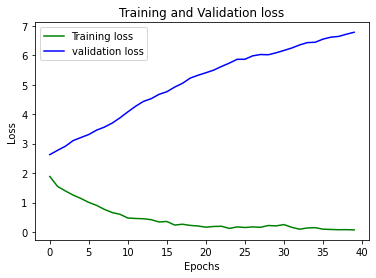

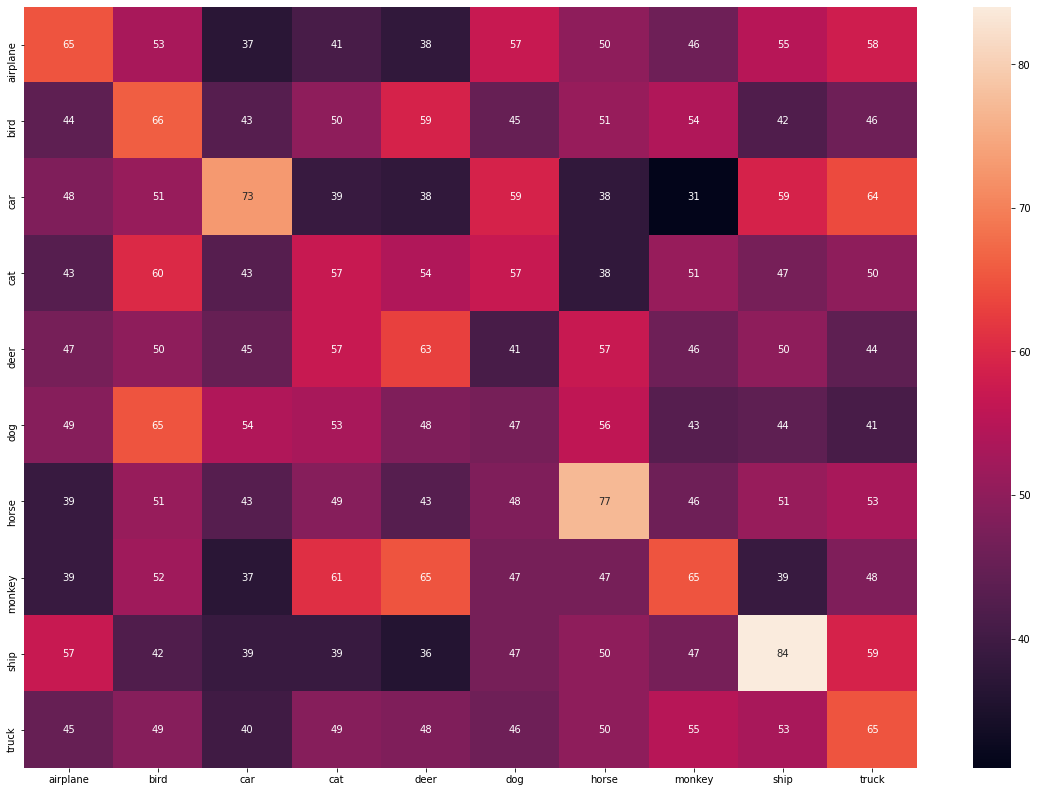

In [41]:

    #Experiment with BatchNorm after all the ConvLayers and FC layers
    print('\nBatch Normalization\n')
    exp_name = 'batch'
    netbatch = LeNetBatch()
    optimizer  = optim.Adam(netbatch.parameters(),lr=1e-3)
    experiment(train_ds,test_ds,val_ds,test_loader,val_loader,netbatch,optimizer,exp_name)
    


Batch Normalization only after the first convolution layer

TRAINING

EPOCH: 0/40
Train Loss: 2.1214    Validation Loss: 2.3075

EPOCH: 1/40
Train Loss: 1.7979    Validation Loss: 2.3759

EPOCH: 2/40
Train Loss: 1.6778    Validation Loss: 2.2222

EPOCH: 3/40
Train Loss: 1.6108    Validation Loss: 2.2487

EPOCH: 4/40
Train Loss: 1.5675    Validation Loss: 2.2155

EPOCH: 5/40
Train Loss: 1.5309    Validation Loss: 2.2408

EPOCH: 6/40
Train Loss: 1.5093    Validation Loss: 2.2029

EPOCH: 7/40
Train Loss: 1.4204    Validation Loss: 2.2287

EPOCH: 8/40
Train Loss: 1.3800    Validation Loss: 2.4833

EPOCH: 9/40
Train Loss: 1.3953    Validation Loss: 2.1348

EPOCH: 10/40
Train Loss: 1.3207    Validation Loss: 2.1192

EPOCH: 11/40
Train Loss: 1.2878    Validation Loss: 2.1591

EPOCH: 12/40
Train Loss: 1.2752    Validation Loss: 2.1136

EPOCH: 13/40
Train Loss: 1.2484    Validation Loss: 2.1639

EPOCH: 14/40
Train Loss: 1.1903    Validation Loss: 2.1324

EPOCH: 15/40
Train Loss: 1.1640    Vali

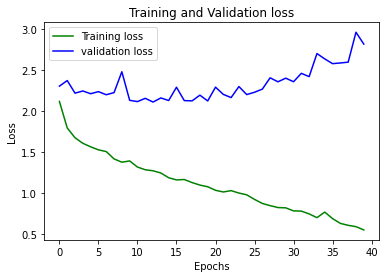

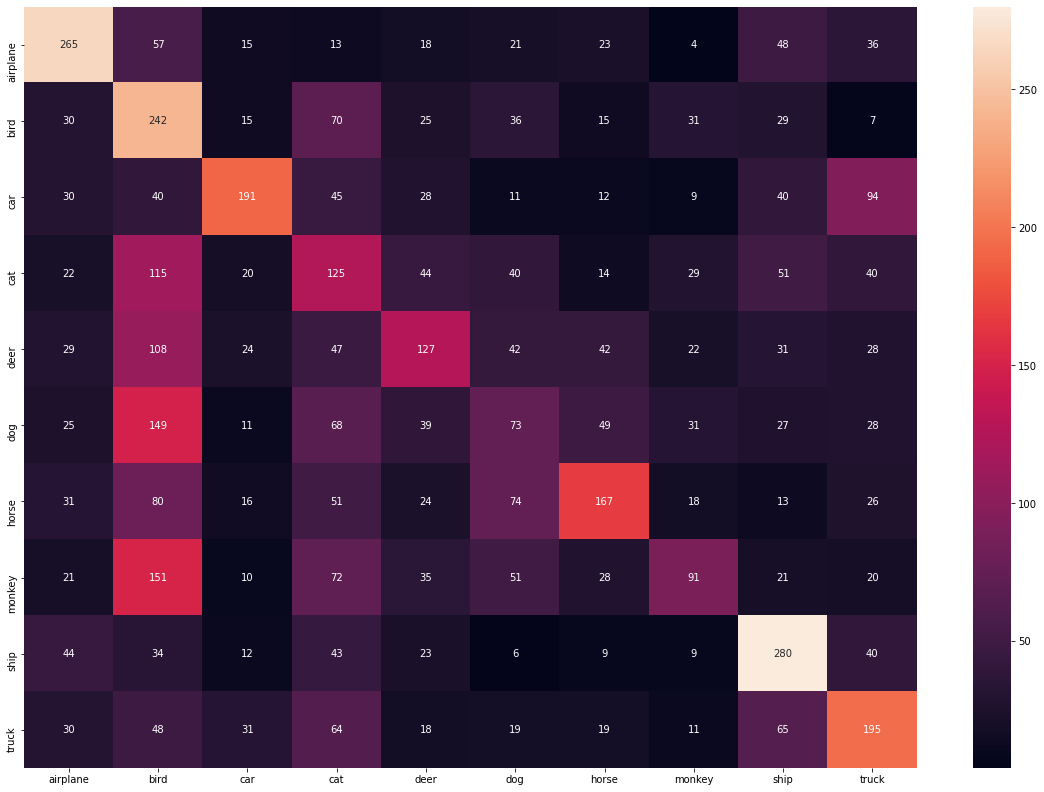

In [42]:
    
    
    #Experiment with Batch Normalization only after the first ConvLayer
    print('\nBatch Normalization only after the first convolution layer\n')
    exp_name = 'batchcl1'
    netbatch = LeNetExp()
    optimizer  = optim.Adam(netbatch.parameters(),lr=1e-3)
    experiment(train_ds,test_ds,val_ds,test_loader,val_loader,netbatch,optimizer,exp_name)
    